# Multistage Neural Network
Aravind Kavuturu, June 2024, Johns Hopkins University

## Introduction
This notebook is a reproduction of the codebase found at https://github.com/YaoGroup/MultistageNN, based on the paper, "Multi-stage neural networks: Function approximator of machine precision" by Yongji Wang and Ching-Yao Lai. "Multi-stage neural networks: Function approximator of machine precision" authored by Yongji Wang and Ching-Yao Lai.

The code has been reproduced using Pytorch with modern features for train/optimize loops.

### Libraries
The main library used in this project is Pytorch, with NumPy and MatPlotLib used for utility.

In [1]:
import torch
from torch import nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt

### Main Classes

The two main classes implemented for replicating the original framework are a Linear layer class, and a NeuralNetStage class. The NeuralNetStage is analogous to the "PhysicsInformedNN" in the Regression section of the reference codebase. Each NeuralNetStage is comprised of 5 layers of nodes (or 4 layers of weights), with three hidden layers of equal size, and the input/output layers of equal size.

The Linear layer starts with Xavier normal distributed weights and zeroed biases. The activation functions applied to each layer vary based on the stage and layer number, and the value of the weight scale factor $\kappa$ also varies similarly. The forward pass is a simple linear combination: $$\hat{y} = \kappa * (\textbf{X} \cdot \textbf{W}) + \textbf{b}$$ An activation function of either $\sin$, $\tanh$, or no activation is chosen based on layer and stage position. 

The train loop uses an Adam optimizer with mean squared error as the loss criterion. This is the portion of code that varies most with the original codebase, as it is the modern equivalent to the `adam_function` and `minimize` combination used previously.

In [10]:
''' 
Linear Module implements a single layer of a stage in the Multistage Neural Network

Weights are initialized using Xavier normal distribution, and biases are initialized at zero

Activation function is chosen by:
- If it is the first layer and not the first stage, we use a sin activation
- If it is the last layer of any stage, we use no activation function
- Otherwise, we use a tanh activation function
'''
class Linear(nn.Module):
    def __init__(self, layer_num, in_dim, out_dim, act=0, kappa=None):
        # use nn.Module initialization
        super(Linear, self).__init__() 

        # initialize weights as nn.Parameter with Xavier Normal distribution
        self.weight = nn.Parameter(torch.zeros(in_dim, out_dim, dtype=torch.float64, requires_grad=True))
        nn.init.xavier_normal_(self.weight)

        # initialize biases as nn.Parameter of all zeros
        self.bias = nn.Parameter(torch.zeros(out_dim, dtype=torch.float64, requires_grad=True))

        # metadata on current Linear layer
        self.layer_num = layer_num
        self.kappa = kappa if kappa else 1
        if act == 0: self.act = torch.tanh
        elif act == 1: self.act =  torch.sin
        else: self.act = None

    # Forward pass function used in computing outputs
    def forward(self, x):
        # kappa * (x @ W) + b
        # use kappa when applicable (first linear layer of each stage)
        self.out = self.kappa * torch.matmul(x, self.weight) + self.bias

        # use activation function when applicable (all layers but the last of each stage)
        if self.act != None: self.out = self.act(self.out)
        return self.out
    
    # reset parameters of model to initial distributions for retraining/debugging
    def reset_parameters(self):
        nn.init.xavier_normal_(self.weight)
        nn.init.zeros_(self.bias)

'''
NeuralNetStage is the implementation of a single stage of the Multistage Neural Net (MSNN) architecture
'''
class NeuralNetStage(nn.Module):
    def __init__(self, stage_num, reg_dim, n_hidden, kappa=None):
        # use nn.Module initializiation
        super(NeuralNetStage, self).__init__()

        # init metadata for stage
        self.stage_num = stage_num
        self.act = 0 if stage_num == 1 else 1

        # neural net architecture of four sequential linear layers
        self.layers = nn.Sequential(Linear(1, reg_dim, n_hidden, self.act, kappa), 
                        Linear(2, n_hidden, n_hidden), 
                        Linear(3, n_hidden, n_hidden),
                        Linear(4, n_hidden, reg_dim, act=2))
    
    # invoke each layer's forward pass function sequentially
    def forward(self, x):
        self.out = self.layers(x)
        return self.out

    # helper function to reset parameters of every layer
    def reset_parameters(self):
        for layer in self.layers:
            layer.reset_parameters()

    # Main training loop
    def train(self, x_train, y_train, lr, itr):
        # initialize optimizer as Adam with learning rate = lr and loss criterion as Mean Squared Error
        optim = torch.optim.Adam(self.parameters(), lr)
        criterion = nn.MSELoss()
        scale = (torch.max(torch.abs(y_train)) / 2) ** 2
        
        # loop data (loss accumulator, max iterations) + reset parameters before training
        lossi = []
        max_steps = itr
        self.reset_parameters()
        print(f"Stage {self.stage_num} Training:")
        
        # train loop
        for i in range(max_steps):
            # initialize inputs/labels as pytorch variables
            inputs = Variable(x_train)
            labels = Variable(y_train)

            # zero all gradients in weights
            optim.zero_grad()

            # compute output logits from neural net forward pass
            outputs = self(inputs)

            # compute MSE loss and backpropagate loss from gradients
            loss = criterion(outputs, labels) * scale
            loss.backward()

            # step optimizer
            optim.step()

            # print current loss every 1000 iterations
            if i % 1000 == 0:
                print(f'{i:7d}/{max_steps:4d}: {loss.item()}')
                
            lossi.append(loss.item())
    
    # Main prediction loop
    def predict(self, x_train):
        # ensure pytorch doesn't compute any gradients
        with torch.no_grad():
            y_pred = self(Variable(x_train))
        
        # predict from network output and return numpy array of estimate
        return y_pred.detach().numpy()
    
    # helper function to find number of zeros for computing next stage's kappa value
    def find_zeros(self, diff):
        idx_zero = np.where(diff[0:-1, 0] * diff[1:, 0] < 0)[0]
        num_zeros = idx_zero.shape[0]
        return num_zeros
    
    # helper function to compute H for first layer's forward pass (data preprocessing step)
    def compute_H(self, lt, ut, x):
        self.H = 2.0 * (x - lt) / (ut - lt) - 1.0
        self.H = self.H.type(torch.float64)
        return self.H


### Data Initialization

The data is split to train and eval for the input function to approximate, `func`. The input features `x_train` are scaled by $\frac12 \max(|x\_train|)$ and are further normalized using the upper and lower bounds `lx` and `ux`.

In [11]:
np.random.seed(234)
gen = torch.manual_seed(234)
N_eval = 8000

# define test function to approximate
def func(x):
    y = (1 - (x**2) / 2) * np.cos(30*(x + 0.5*(x ** 3)))
    return y

# train dataset for training first stage
# x = inputs, y = labels
x_train_np = np.linspace(-1.02, 1.02, 1501, dtype=np.float64)[:, None]
x_train = torch.from_numpy(x_train_np)
y_train = func(x_train)

# lower/upper bounds on x values used for normalizing when computing H
lx = x_train_np.min(0)
ux = x_train_np.max(0)

# scaling x_train by half of abs max
scale = torch.max(torch.abs(y_train)) / 2
y_train /= scale

# eval dataset for validation
x_eval_np = np.linspace(-1, 1, N_eval, dtype=np.float64)[:, None]
x_eval = torch.from_numpy(x_eval_np)
y_eval = func(x_eval)

### Stage Trainings

Each stage is initialized by the number of input features (1D equations have `reg_dim = 1`, 2D `=2`, etc.) and number of hidden nodes in each hidden layer. This number increases from 20 to 30 after the second stage. Additionally, the number of datapoints increases from 1501 to 4801 after the second stage.

$\kappa$ is found from the number of zeros of the input dataset - in future work, this can be changed to incorporate the dominant frequency instead, as mentioned in the paper.

`H` is the normalized input to the neural network, copying from the original codebase.

The running evaluation prediction is stored in `y_p`.


In [12]:
# reg_dim is dimensionality of func
reg_dim = 1
n_hidden1 = 20
n_hidden2 = 30
lr = 1e-5

'''First Stage Training'''
# start with kappa = 1 for first stage (no scale factor needed)
stage1 = NeuralNetStage(1, reg_dim, n_hidden1)

# H1 is used as normalized input to training of neural net
H1 = stage1.compute_H(lx, ux, x_train)

# train first stage and create prediction set
# y_p1 is used for evaluation, y_pred1 is used for computing residues
stage1.train(H1, y_train, lr=1e-3, itr=3000)
y_p1 = stage1.predict(x_eval)
y_pred1 = stage1.predict(x_train)
y_p = y_p1

# compute residues for input to second stage and second stage kappa 
y_train2 = y_train - y_pred1
kappa2 = 3 * stage1.find_zeros(y_train2)

'''Second Stage Training'''
# increase training for second stage to 5000 iterations
stage2 = NeuralNetStage(2, reg_dim, n_hidden1, kappa2)
H2 = stage2.compute_H(lx, ux, x_train)

stage2.train(H2, y_train, lr=1e-3, itr=5000)
y_p2 = stage2.predict(x_eval)
y_pred2 = stage2.predict(x_train)

# running total evaluation prediction after each stage of training adds precision
y_p += y_p2


'''Third Stage Training'''
# increase number of datapoints from 1501 to 4801 for third/fourth stage -> x_train2
x_train_4801_np = np.linspace(-1.02, 1.02, 4801, dtype=np.float64)[:, None]
x_train_4801 = torch.from_numpy(x_train_4801_np)
y_train_4801 = func(x_train_4801)

# compute third stage residue set and kappa from retraining on larger dataset
y_pred1 = stage1.predict(x_train_4801)
y_pred2 = stage2.predict(x_train_4801)
y_train3 = y_train_4801 - y_pred1 - y_pred2 
kappa3 = 3 * stage2.find_zeros(y_train3)

# use 30 hidden nodes in each layer instead of 20
stage3 = NeuralNetStage(3, reg_dim, n_hidden2, kappa3)
H3 = stage3.compute_H(lx, ux, x_train_4801)

stage3.train(H3, y_train3, lr=1e-3, itr=5000)
y_p3 = stage3.predict(x_eval)
y_pred3 = stage3.predict(x_train_4801)
y_p += y_p3

'''Fourth Stage Training'''
y_train4 = y_train_4801 - y_pred1 - y_pred2 - y_pred3
kappa4 = 3 * stage3.find_zeros(y_train4)

stage4 = NeuralNetStage(4, reg_dim, n_hidden2, kappa4)
H4 = stage4.compute_H(lx, ux, x_train_4801)

stage4.train(H4, y_train4, lr=1e-3, itr=5000)
y_p4 = stage4.predict(x_eval)
y_p += y_p4

Stage 1 Training:
      0/3000: 1.7361823888866268
   1000/3000: 1.4110186817051757
   2000/3000: 1.410940128677266
Stage 2 Training:
      0/5000: 1.7186167030304393
   1000/5000: 0.0002314588068082754
   2000/5000: 6.42586414719395e-05
   3000/5000: 2.7652627447177425e-05
   4000/5000: 0.00015037989081512855
Stage 3 Training:
      0/5000: 0.2012247579534913
   1000/5000: 1.821841130426275e-05
   2000/5000: 7.110759033423567e-06
   3000/5000: 6.806417057165747e-06
   4000/5000: 8.06382495938004e-06
Stage 4 Training:
      0/5000: 0.5774757297232326
   1000/5000: 0.00015844348182103048
   2000/5000: 4.166031345078182e-05
   3000/5000: 1.853852916445604e-05
   4000/5000: 1.0999964650517139e-05


## Plotting Results

The below plots show the results of the regression from the four stage training. The first plot is the target function and the approximation, and each subsequent plot is the residues of the previous plot's first pass approximation.

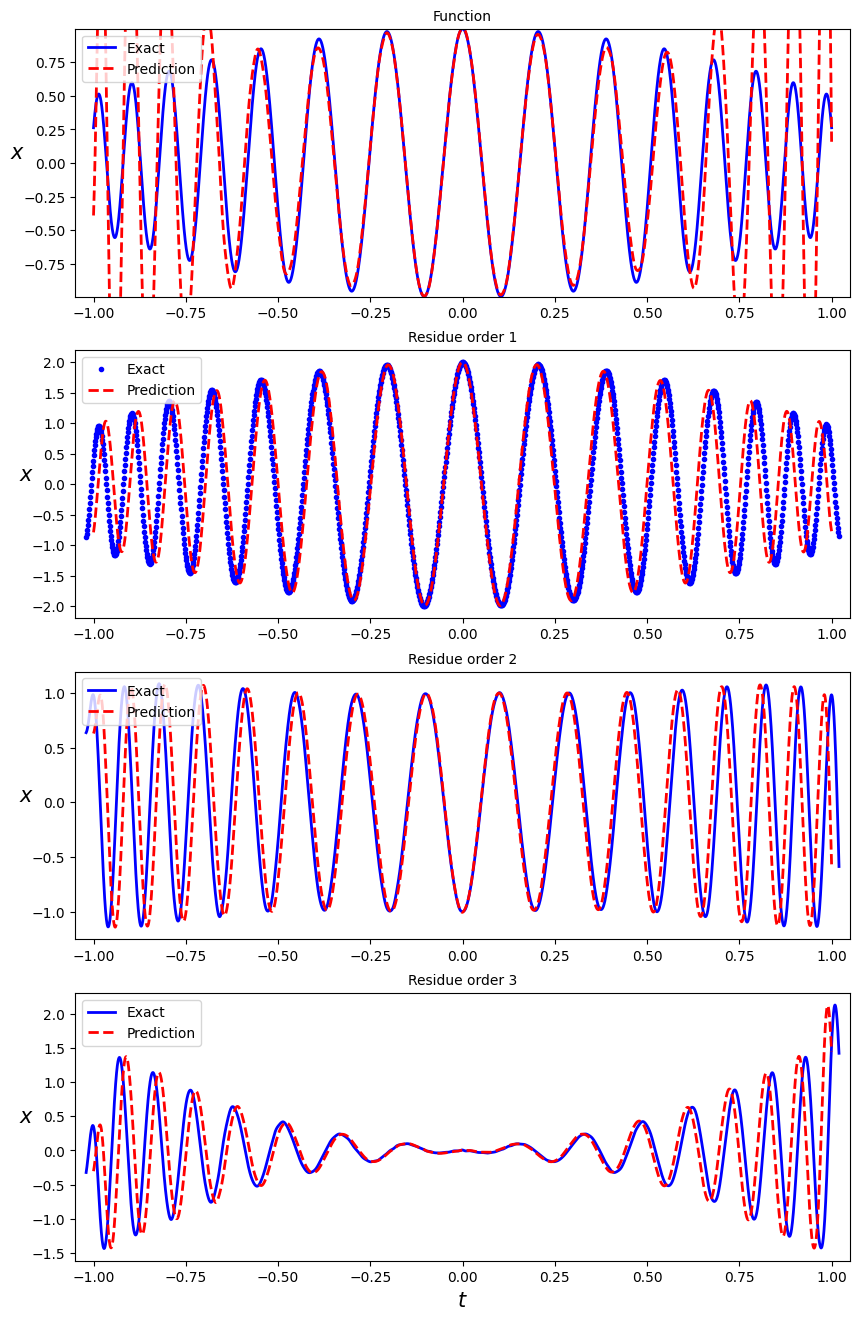

In [14]:
ymin = y_eval.numpy().min()
ymax = y_eval.numpy().max()

fig = plt.figure(figsize=[10, 16], dpi=100)
ax = plt.subplot(411)
ax.plot(x_eval, y_eval, 'b-', linewidth = 2, label = 'Exact')
ax.plot(x_eval, y_p, 'r--', linewidth = 2, label = 'Prediction')
ax.set_ylabel('$x$', fontsize=15, rotation = 0)
ax.set_title('Function', fontsize=10)
ax.set_xlim([-1.05, 1.05])
ax.set_ylim([ymin,ymax])
ax.legend(loc="upper left")

ax1 = plt.subplot(412)
ax1.plot(x_train, y_train2, 'b.', linewidth=2, label='Exact')
ax1.plot(x_eval, y_p2, 'r--', linewidth=2, label='Prediction')
ax1.set_ylabel('$x$', fontsize=15, rotation=0)
ax1.set_title('Residue order 1', fontsize=10)
ax1.set_xlim([-1.05, 1.05])
ax1.legend(loc="upper left")

ax2 = plt.subplot(413)
ax2.plot(x_train_4801, y_train3, 'b-', linewidth=2, label='Exact')
ax2.plot(x_eval, y_p3, 'r--', linewidth=2, label='Prediction')
ax2.set_ylabel('$x$', fontsize = 15, rotation = 0)
ax2.set_title('Residue order 2', fontsize = 10)
ax2.set_xlim([-1.05, 1.05])
ax2.legend(loc="upper left")

ax3 = plt.subplot(414)
ax3.plot(x_train_4801, y_train4, 'b-', linewidth = 2, label = 'Exact')
ax3.plot(x_eval, y_p4, 'r--', linewidth=2, label='Prediction')
ax3.set_xlabel('$t$', fontsize = 15)
ax3.set_ylabel('$x$', fontsize = 15, rotation = 0)
ax3.set_title('Residue order 3', fontsize = 10)
ax3.set_xlim([-1.05, 1.05])
ax3.legend(loc="upper left")